### Import the necessary program libraries

In [1]:
import pandas as pd
import plotly.graph_objects as go
from classes import KMeansClusterMain, BaseLoader
import plotly.express as px
from funcs import to_float, get_density, get_color
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as mcolors
from sqlalchemy import create_engine
from settings import mariadb_string, mariadb_config

### Select the data

In [55]:
sql_query = """select 
	*
from
	stock_price s
where
	s.symbol = '{}'
group BY
	s.`date`
order by
	s.`date` asc;"""

loader = BaseLoader(mariadb_config)
symbol = loader.choose_id()
df_stock = pd.read_sql(sql_query.format(symbol), create_engine(mariadb_string))
df_stock["date"] = pd.to_datetime(df_stock["date"])
df_stock.info()

Please choose the symbol from the index which data should be analysed.
symbol AMZN: Amazon
symbol BKNG: Booking Holdings
symbol DASH: DoorDash
symbol HD: Home Depot
symbol LOW: Lowe’s
symbol MCD: McDonald's
symbol NKE: Nike
symbol SBUX: Starbucks
symbol TJX: TJX Companies
symbol TSLA: Tesla
You can typ 'q' to quit.


symbol:  MCD


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  1318 non-null   object        
 1   date    1318 non-null   datetime64[ns]
 2   open    1318 non-null   float64       
 3   high    1318 non-null   float64       
 4   low     1318 non-null   float64       
 5   close   1318 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 61.9+ KB


In [56]:
df_stock.head()

,symbol,date,open,high,low,close
0,MCD,2020-04-20,184.45,185.78,181.55,181.65
1,MCD,2020-04-21,177.37,179.39,176.10,177.58
2,MCD,2020-04-22,180.75,187.73,180.75,186.48
3,MCD,2020-04-23,186.16,187.33,181.32,182.04
4,MCD,2020-04-24,183.26,184.35,180.86,184.02


### Get the Volatility

In [57]:
# Volatility Calculation
df_stock['volatility_max'] = (df_stock['high'] - df_stock['low']).rolling(21).max()
df_stock['volatility_mean'] = (df_stock['high'] - df_stock['low']).rolling(21).mean()

In [69]:
df_stock.head()

,symbol,date,open,high,low,close,volatility_max,volatility_mean,perc_change,cluster,density,cluster_str
20,MCD,2020-05-18,180.06,181.15,178.11,179.83,7.81,4.563333,3.463552,2,NaN,2
21,MCD,2020-05-19,180.12,181.46,178.07,179.57,7.81,4.523333,-0.144581,1,NaN,1
22,MCD,2020-05-20,182.00,184.60,180.57,184.10,7.81,4.558571,2.522693,2,NaN,2
23,MCD,2020-05-21,184.18,185.48,182.11,185.08,7.81,4.386667,0.532319,1,NaN,1
24,MCD,2020-05-22,184.48,185.35,183.18,184.41,7.81,4.203810,-0.362006,1,NaN,1


In [59]:
df_stock.tail()

,symbol,date,open,high,low,close,volatility_max,volatility_mean
1313,MCD,2025-07-11,298.14,302.74,297.29,299.91,8.25,4.602524
1314,MCD,2025-07-14,299.18,302.07,294.83,301.88,8.25,4.661095
1315,MCD,2025-07-15,301.30,302.79,299.24,299.62,8.25,4.681857
1316,MCD,2025-07-16,299.78,300.48,296.21,298.90,8.25,4.696619
1317,MCD,2025-07-17,299.77,302.45,298.42,300.37,7.30,4.495667


### Check the chart

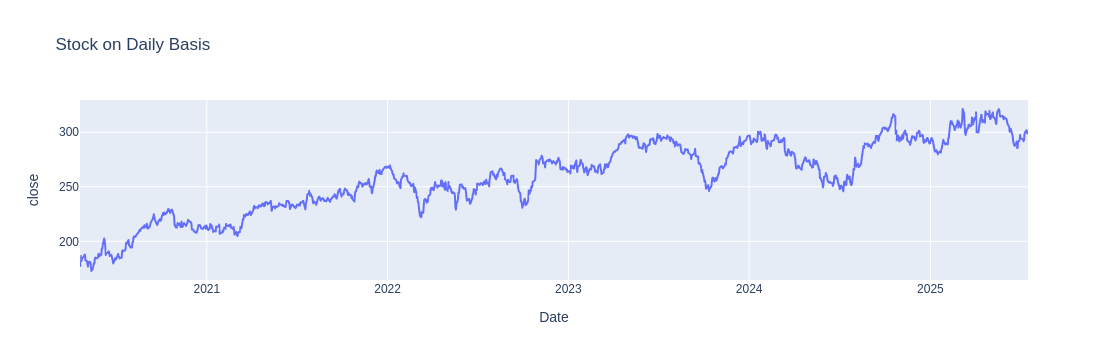

In [60]:
fig = px.line(df_stock, x="date", y="close", title="Stock on Daily Basis", 
              labels={"date": "Date"})

fig.show()

### The Mean Volatility

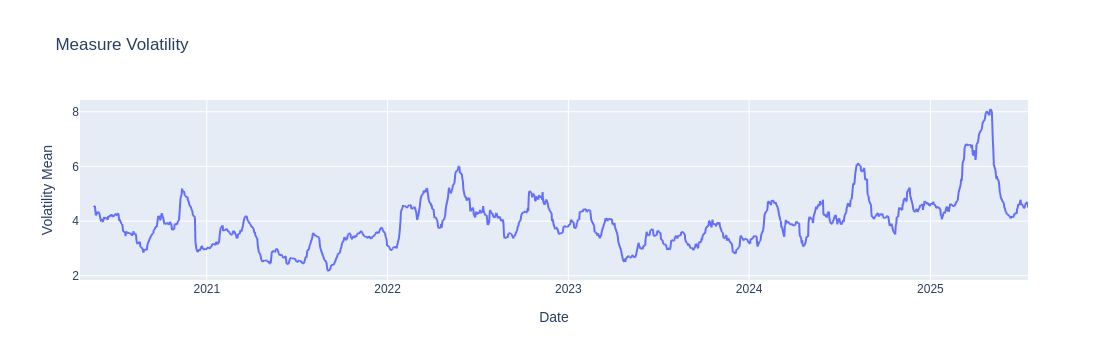

In [61]:
fig = px.line(df_stock, x="date", y="volatility_mean", title="Measure Volatility", 
              labels={"date": "Date", "volatility_mean": "Volatility Mean"})
fig.show()

### The Max Volatility

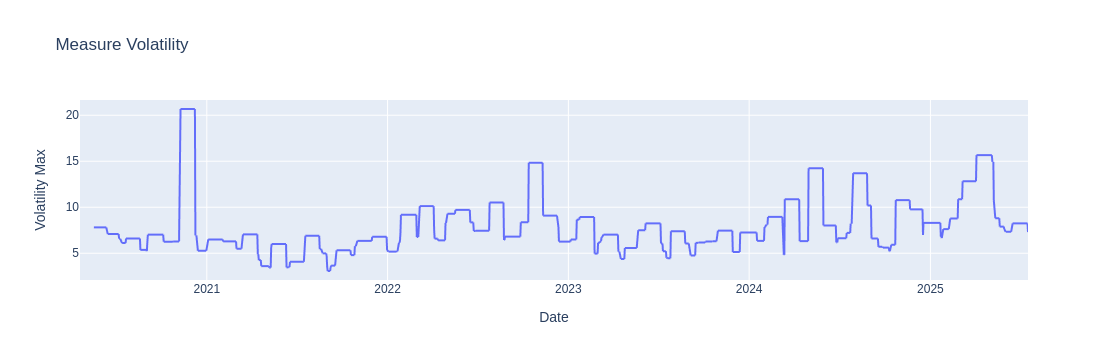

In [62]:
fig = px.line(df_stock, x="date", y="volatility_max", title="Measure Volatility",
              labels={"date": "Date", "volatility_max": "Volatility Max"})
fig.show()

### Compute the main process

1. Calculate the percentage change on daily bases

2. Within the percentage change datapoints calculate the clusters with the help of the KMeans-Clustering-Algorithm

3. Calculate the necessary density column with the cluster labels and sum up the kmeans centroids with that and save them

In [63]:
# Compute the percentage change
df_stock["perc_change"] = df_stock["close"].pct_change()
df_stock.dropna(inplace=True)
df_stock = df_stock[df_stock['perc_change'] != 0.0]

# Here comes KMeans
datapoints = df_stock["perc_change"].to_list()
kmeans = KMeansClusterMain(3)
kmeans.fit(datapoints) 

# Assign the clusters
df_stock["cluster"] = kmeans.labels
df_stock["cluster"] = pd.to_numeric(df_stock["cluster"])

# Get the density for the colormap
df_stock["density"] = df_stock["cluster"].rolling(21).apply(get_density, kwargs={'orig_density': kmeans.centroids})

# cluster_str needed for kmeans volatility cluster graph.
df_stock["cluster_str"] = df_stock.cluster.astype(str)
df_stock['perc_change'] = df_stock['perc_change'] * 100

print(df_stock.isna().any())
print(df_stock.info())

symbol             False
date               False
open               False
high               False
low                False
close              False
volatility_max     False
volatility_mean    False
perc_change        False
cluster            False
density             True
cluster_str        False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Index: 1295 entries, 20 to 1317
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   symbol           1295 non-null   object        
 1   date             1295 non-null   datetime64[ns]
 2   open             1295 non-null   float64       
 3   high             1295 non-null   float64       
 4   low              1295 non-null   float64       
 5   close            1295 non-null   float64       
 6   volatility_max   1295 non-null   float64       
 7   volatility_mean  1295 non-null   float64       
 8   perc_change      1295 non-null   float64       
 9

### Determine the boundaries of the density

count    1275.000000
mean        0.009282
std         0.042016
min        -0.116491
25%        -0.016507
50%         0.012183
75%         0.040016
max         0.113878
Name: density, dtype: float64


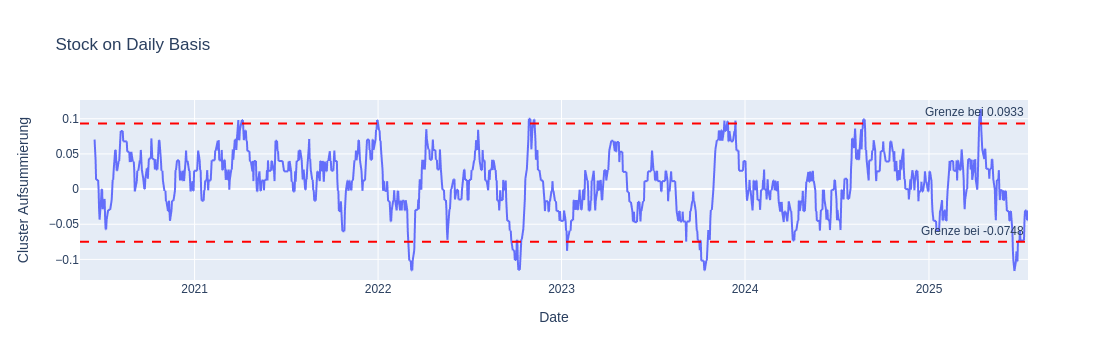

In [64]:
# Calculate the density
describe_ser = df_stock["density"].describe()
upper_limit = describe_ser["mean"] + (describe_ser["std"] * 2)
lower_limit = describe_ser["mean"] - (describe_ser["std"] * 2)
print(describe_ser)

# Show the density
fig = px.line(df_stock, x="date", y="density", title="Stock on Daily Basis",
                  labels={"date": "Date", "density": "Cluster Aufsummierung"})

fig.add_hline(y=upper_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(upper_limit,4)}")
fig.add_hline(y=lower_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(lower_limit,4)}")


fig.show()

### Checking the volatility in percentage daily changes

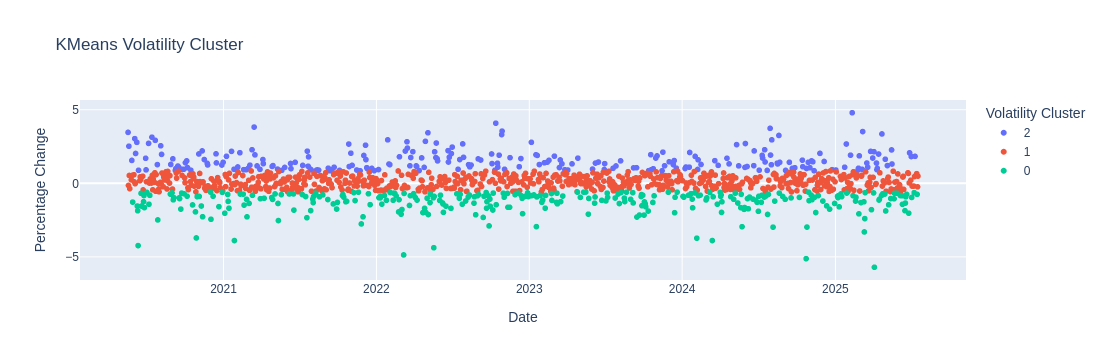

In [66]:
fig = px.scatter(df_stock, x="date", y="perc_change", color="cluster_str", 
                 title="KMeans Volatility Cluster", 
                 labels={"date": "Date", "perc_change": "Percentage Change", 
                         "cluster_str": "Volatility Cluster",})
fig.show()

In [67]:
# Need it for the sell order
df_stock.loc[df_stock['cluster'] == 2]['perc_change'].describe()


count    252.000000
mean       1.588170
std        0.705242
min        0.848675
25%        1.060447
50%        1.376911
75%        1.913976
max        4.797825
Name: perc_change, dtype: float64

### Color the price history according to the column density

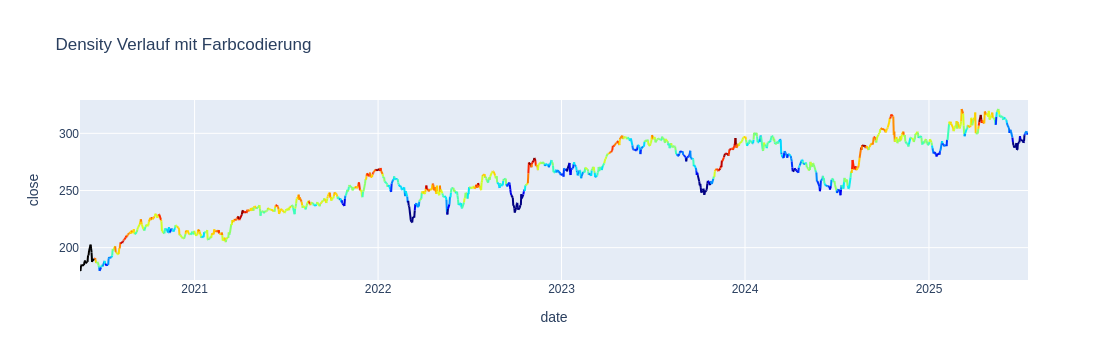

Untere Grenze (vmin): -0.07
Obere Grenze (vmax): 0.09
Mittelwert: 0.01


In [68]:
# Statistical limits for clipping
vmin = lower_limit
vmax = upper_limit

# Create normalization
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

# Create plotly-figure
fig = go.Figure()

# Draw line segments with colors based on density
for i in range(len(df_stock) - 1):
    density_value = df_stock["density"].iloc[i]
    color = get_color(density_value, norm)
    
    fig.add_trace(go.Scatter(
        x=df_stock["date"].iloc[i:i+2],  # Zwei Punkte verbinden
        y=df_stock["close"].iloc[i:i+2],
        mode="lines",
        line=dict(color=color, width=2),
        showlegend=False,
    ))

# Adjust layout
fig.update_layout(
    title="Density Verlauf mit Farbcodierung",
    xaxis_title="date",
    yaxis_title="close",
    # Add colorbar
    coloraxis=dict(
        colorbar=dict(
            title="Density",
            ticktext=["Niedrig (Blau)", "Neutral (Grün)", "Hoch (Rot)"],
            tickvals=[vmin, (vmin+vmax)/2, vmax]
        ),
        colorscale="jet",
        cmin=vmin,
        cmax=vmax
    )
)

fig.show()

# Optional: Ausgabe der Grenzwerte zur Kontrolle
print(f"Untere Grenze (vmin): {vmin:.2f}")
print(f"Obere Grenze (vmax): {vmax:.2f}")
print(f"Mittelwert: {describe_ser['mean']:.2f}")